In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import LocallyLinearEmbedding

In [35]:
def mds_reduction(data, target_dimension):
  return pd.DataFrame(MDS(n_components=target_dimension,eps=1e-4,n_init=15).fit_transform(data))

def get_eigens(X):
    pca = PCA()
    pca.fit_transform(X)
    return pca.explained_variance_ratio_, pca.components_

def find_normal_vectors(eigens, vectors, THRESHOLD=0.001):
  normal_vectors = []
  for i in range(len(eigens)):
    if eigens[i] < THRESHOLD:
      normal_vectors.append(vectors[i])
  return normal_vectors

def normalize_with_center(X, c):
  for i in range(len(X)):
    X.iloc[i]-= c
  return preprocessing.normalize(X)

def variance(data):
  mean = sum(data) / len(data)
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / len(data)
  return variance

def get_reduced(X, target_dimension, reduction_type):
  X_transformed = []
  if reduction_type == 'iso':
    embedding = Isomap(n_components=target_dimension, n_neighbors=10)
    X_transformed = embedding.fit_transform(X)
  elif reduction_type == 'pca':
    transformer = PCA(n_components=target_dimension)
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'k-pca':
    transformer = KernelPCA(n_components=target_dimension, kernel='rbf')
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'tsne':
    X_transformed = TSNE(n_components=target_dimension, learning_rate='auto', init='pca').fit_transform(manifold_list[i])
  elif reduction_type == 'mds':
    X_transformed = mds_reduction(X,target_dimension)
  elif reduction_type == 'LLE':
    X_transformed = LocallyLinearEmbedding(n_components=target_dimension, n_neighbors=30).fit_transform(manifold_list[i])
  return X_transformed

def get_cluster(X, num_cluster, cluster_type):
  if cluster_type == 'GMM':
    model = mixture.GaussianMixture(n_components=num_cluster, covariance_type='full', n_init=100)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'k-means':
    model=KMeans(n_clusters=num_cluster, n_init=10, max_iter=10000)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'HS':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'H':
    model = AgglomerativeClustering(n_clusters=num_cluster)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'spectral':
    model = SpectralClustering(assign_labels='discretize', n_clusters=num_cluster, random_state=77, n_init=1)
    model.fit(X)
    labels = model.labels_
  return labels

# Epsilon for DBSCAN
def show_distance_graph(X):
  neigh = NearestNeighbors(n_neighbors=5)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  print(distances[-40:])
  plt.figure(figsize=(10,5))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()

%matplotlib notebook
#Visualization in 4D
def visualize_4d(frame, hot=True):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(frame.iloc[:,0])
  if len(frame.columns) > 1:
    y = np.array(frame.iloc[:,1])
  if len(frame.columns) > 2:
    z = np.array(frame.iloc[:,2])
  if len(frame.columns) == 1:
    img = ax.scatter(x, x, s=2)
  if len(frame.columns) == 2:
    img = ax.scatter(x, y, s=2)
  elif len(frame.columns) == 3:
    img = ax.scatter(x, y, z, s=2)
  else:
    c = np.array(frame.iloc[:,3])
    if hot:
      img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), s=2)
    else:
      img = ax.scatter(x, y, z, c=c, cmap='viridis', s=2)
  plt.show()

### Open Input

In [36]:
# Input
file = open('./R31.txt','r')
d, n, m, k, p = list(map(int,file.readline().split()))
k_list = list(map(int,file.readline().split()))
ar = []
for i in range(n):
  ar.append(list(map(float,file.readline().split())))
df = pd.DataFrame(ar)
df.describe()

,0,1,2
count,29678.000000,29678.000000,29678.000000
mean,419.808233,-69.027823,31.336202
std,255.848084,62.353086,67.380433
min,-29.291716,-205.376219,-101.377696
25%,195.227485,-112.720350,-25.854263
50%,443.645602,-65.691209,21.230403
75%,644.640312,-23.550395,87.041762
max,792.444881,69.779176,156.502445


### Finding Submanifolds

In [37]:
show_distance_graph(df)

[2.68397131 2.71410872 2.77179014 2.79736089 2.79948668 2.80292831
 2.82340054 2.85115594 2.85440788 2.85440788 2.86154689 2.87154542
 2.92417632 2.9247198  2.94249694 2.98068713 2.98068713 2.9923713
 3.01311707 3.02191292 3.03272227 3.04542577 3.09440552 3.1986525
 3.25056251 3.44985529 3.48179325 3.49068065 3.50761618 3.57796232
 3.64987391 3.69912203 3.69912203 3.77817918 3.82911538 3.85473918
 3.92577158 3.9732381  4.00065183 4.04654045]


<IPython.core.display.Javascript object>

In [38]:
#DBSCAN
EPS = 10
MIN_SAMPLES = 3
model_name = 'dbscan'
model = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
model.fit(df[[i for i in range(0,d)]])
df['manifold'] = model.labels_
# print(df[df['manifold'] == -1].describe())
print(df.describe())
visualize_4d(df, hot=False)

                  0             1             2      manifold
count  29678.000000  29678.000000  29678.000000  29678.000000
mean     419.808233    -69.027823     31.336202      5.447200
std      255.848084     62.353086     67.380433      3.360718
min      -29.291716   -205.376219   -101.377696      0.000000
25%      195.227485   -112.720350    -25.854263      3.000000
50%      443.645602    -65.691209     21.230403      6.000000
75%      644.640312    -23.550395     87.041762      8.000000
max      792.444881     69.779176    156.502445     10.000000


<IPython.core.display.Javascript object>

In [39]:
res = df.copy()

for manif in [0, 5, 8, 9, 10]:
  res.loc[res['manifold'] == manif, 'subb'] = get_cluster(res[res['manifold'] == manif][[i for i in range(d)]], num_cluster=2, cluster_type='HS')

res['manifold'] = res.manifold.astype(str) + '-' + res.subb.astype(str)
res['manifold'] = LabelEncoder().fit_transform(res['manifold'])
res = res.drop(['subb'], axis=1)
visualize_4d(res)
print(res.describe())
df = res

<IPython.core.display.Javascript object>

                  0             1             2      manifold
count  29678.000000  29678.000000  29678.000000  29678.000000
mean     419.808233    -69.027823     31.336202      7.544477
std      255.848084     62.353086     67.380433      4.605108
min      -29.291716   -205.376219   -101.377696      0.000000
25%      195.227485   -112.720350    -25.854263      4.000000
50%      443.645602    -65.691209     21.230403      8.000000
75%      644.640312    -23.550395     87.041762     12.000000
max      792.444881     69.779176    156.502445     15.000000


In [40]:
# custom cluster for manifold
s2 = [2, 6, 10]  # HS
s3 = [11] # k-means
final_k_list = [1] * m
cluster_type = ['HS'] * m
for i in s2:
  final_k_list[i] = 2
for i in s3:
  final_k_list[i] = 3
  cluster_type[i] = 'HS'

In [41]:
# Joining the cluster labeling
def join_clusters():
  df['cluster'] = [0]*n
  data_index = [0] * m
  for i in range(n):
    index_manifold = df.at[i,'manifold']
    if index_manifold!=-1:
      df.at[i,'cluster'] = list_labels[index_manifold][data_index[index_manifold]]
      data_index[index_manifold]+=1

single_run = None
list_labels = []
for i in range(m):
  print(i, end=' ')
  labels = get_cluster(df[df['manifold'] == i][[i for i in range(d)]], num_cluster=final_k_list[i], cluster_type=cluster_type[i])
  list_labels.append(labels)
join_clusters()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [42]:
visualize_4d(df[df['manifold'] == 11][[0,1,2,'cluster']], hot=False)

<IPython.core.display.Javascript object>

0


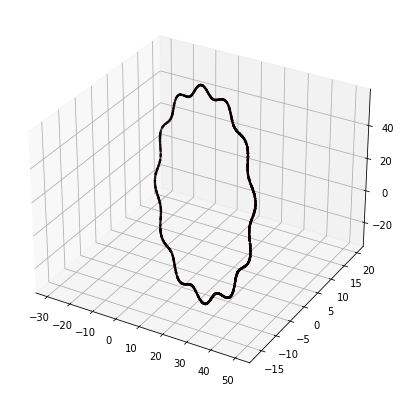

1


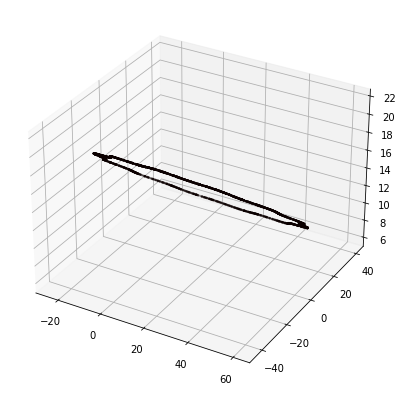

2


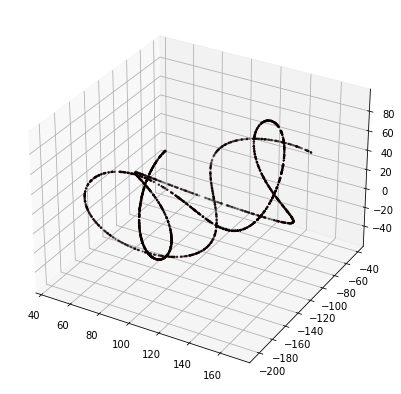

3


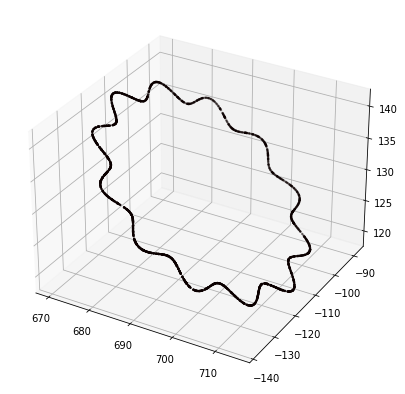

4


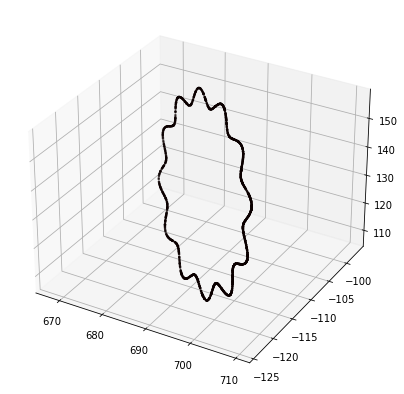

5


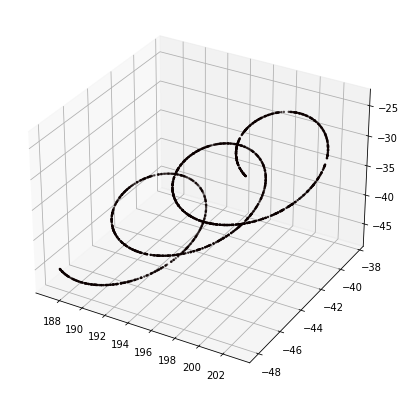

6


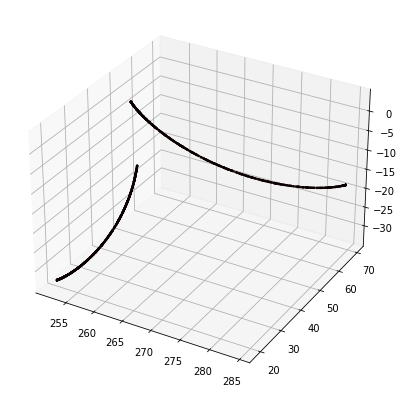

7


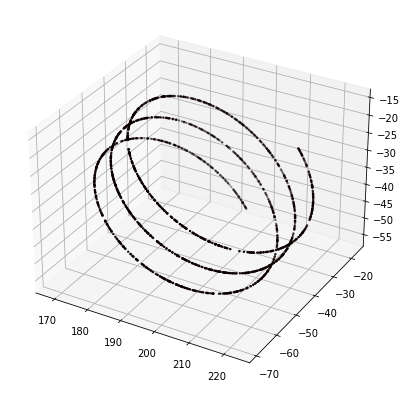

8


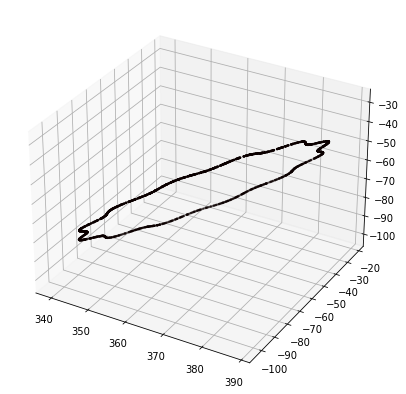

9


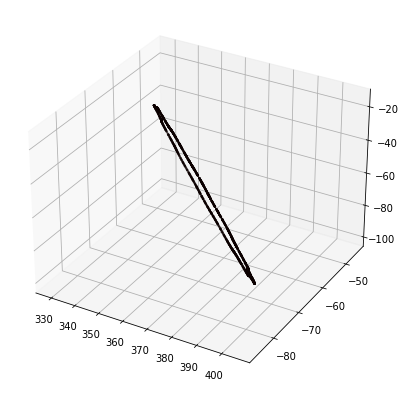

10


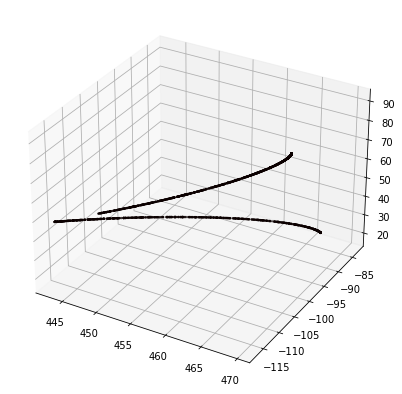

11


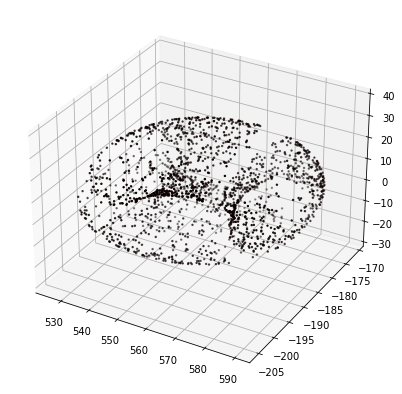

12


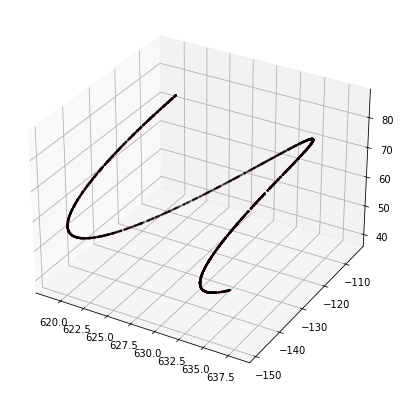

13


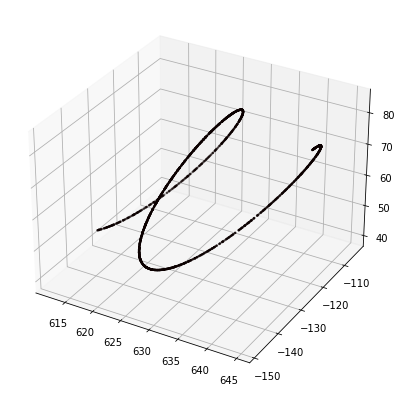

14


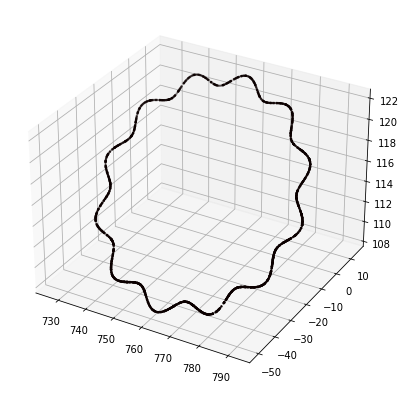

15


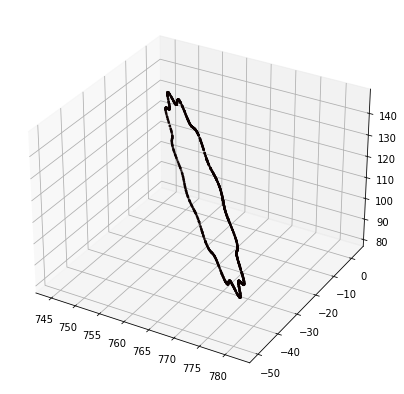

In [43]:
plt.close('all')
%matplotlib inline
for i in range(m):
  print(i)
  visualize_4d(df[df['manifold'] == i])
D = [2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2]

### Output

In [44]:
# Outputting

vectors = [[[] for j in range(0,final_k_list[i])] for i in range(0,m)]
#df.loc[df['column_name'] == some_value]
outliar = []
for i in range(n):
  if df.at[i, 'manifold'] == -1:
    outliar.append(i + 1)
  else:
    vectors[df.at[i, 'manifold']][df.at[i, 'cluster']].append(i + 1)

with open('./output.txt', 'w') as f:
  print(f'{n} {m}', file=f)
  for i in range(m):
    dimension = D[i]
    print(f'{dimension} ' + str(final_k_list[i]) + ' Complex', file=f)
    #for j in range(0,len(A[i])):
    #  print(' '.join(list(map(str,A[i][j]))), file=f)
    #print(' '.join(list(map(str,B[i]))), file=f)
    #print(' '.join(list(map(str, centroids[i]))) + ' ' + str(radius[i]), file=f)
    for j in range(0,final_k_list[i]):
      print(str(len(vectors[i][j])) + ' ' + ' '.join(list(map(str, vectors[i][j]))), file=f)
  print(str(len(outliar)) + ' ' + ' '.join(list(map(str, outliar))), file=f)

